In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Ustawienie ziarna losowości
np.random.seed(42)

In [4]:
# Wczytanie danych (zbior odręcznych cyfr z sklearn)
data = datasets.load_digits()
images = data['images']
targets = data['target']

In [5]:
# Skalowanie pikseli (standaryzacja do [0, 1])
images = images / 16.0

In [6]:
# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.25, random_state=42)


In [7]:
# Spłaszczenie obrazów (wektory 64-elementowe)
X_train = X_train.reshape(-1, 64)
X_test = X_test.reshape(-1, 64)

In [8]:
# Ustawienie parametrów kwantowego systemu
n_qubits = 6  # Liczba kubitów (może być mniejsza niż liczba cech, dlatego zredukujemy dane)
dev = qml.device("default.qubit", wires=n_qubits)

In [9]:
# Funkcja kodowania danych w przestrzeni kwantowej
def encode_data(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

In [10]:
# Kwantowy ansatz (obwód parametryczny)
def variational_circuit(weights):
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)
        qml.RZ(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

In [11]:
# Kwantowy obwód złożony z kodowania i ansatza
@qml.qnode(dev)
def quantum_circuit(params, x):
    encode_data(x)
    variational_circuit(params)
    return qml.expval(qml.PauliZ(0))

In [12]:
# Funkcja kosztu dla klasy k
def cost(params, X, y, target_class):
    y_binary = (y == target_class).astype(float)
    predictions = [quantum_circuit(params, x) for x in X]
    return np.mean((np.array(predictions) - y_binary) ** 2)

In [13]:
# Trenowanie modeli dla każdej klasy
num_classes = 10
params_list = []
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 30

for target_class in range(num_classes):
    print(f"\nTraining quantum model for class {target_class}")
    params = np.random.uniform(low=-np.pi, high=np.pi, size=(n_qubits,))
    losses = []

    for epoch in range(num_epochs):
        params = opt.step(lambda p: cost(p, X_train, y_train, target_class), params)
        current_loss = cost(params, X_train, y_train, target_class)
        losses.append(current_loss)
        print(f"Epoch {epoch+1}: Loss = {current_loss:.4f}")

    params_list.append(params)


Training quantum model for class 0
Epoch 1: Loss = 0.2667
Epoch 2: Loss = 0.2084
Epoch 3: Loss = 0.1678
Epoch 4: Loss = 0.1406
Epoch 5: Loss = 0.1226
Epoch 6: Loss = 0.1110
Epoch 7: Loss = 0.1035
Epoch 8: Loss = 0.0987
Epoch 9: Loss = 0.0956
Epoch 10: Loss = 0.0937
Epoch 11: Loss = 0.0924
Epoch 12: Loss = 0.0916
Epoch 13: Loss = 0.0911
Epoch 14: Loss = 0.0908
Epoch 15: Loss = 0.0906
Epoch 16: Loss = 0.0904
Epoch 17: Loss = 0.0903
Epoch 18: Loss = 0.0903
Epoch 19: Loss = 0.0902
Epoch 20: Loss = 0.0902
Epoch 21: Loss = 0.0902
Epoch 22: Loss = 0.0902
Epoch 23: Loss = 0.0902
Epoch 24: Loss = 0.0902
Epoch 25: Loss = 0.0902
Epoch 26: Loss = 0.0902
Epoch 27: Loss = 0.0902
Epoch 28: Loss = 0.0902
Epoch 29: Loss = 0.0902
Epoch 30: Loss = 0.0902

Training quantum model for class 1
Epoch 1: Loss = 0.2078
Epoch 2: Loss = 0.1743
Epoch 3: Loss = 0.1497
Epoch 4: Loss = 0.1323
Epoch 5: Loss = 0.1202
Epoch 6: Loss = 0.1120
Epoch 7: Loss = 0.1066
Epoch 8: Loss = 0.1029
Epoch 9: Loss = 0.1005
Epoch 10: 

In [14]:
# Analiza danych: rozkład etykiet w zbiorze treningowym
unique, counts = np.unique(y_train, return_counts=True)
print("Rozkład etykiet w zbiorze treningowym:", dict(zip(unique, counts)))

Rozkład etykiet w zbiorze treningowym: {0: 135, 1: 145, 2: 139, 3: 137, 4: 126, 5: 123, 6: 136, 7: 138, 8: 136, 9: 132}


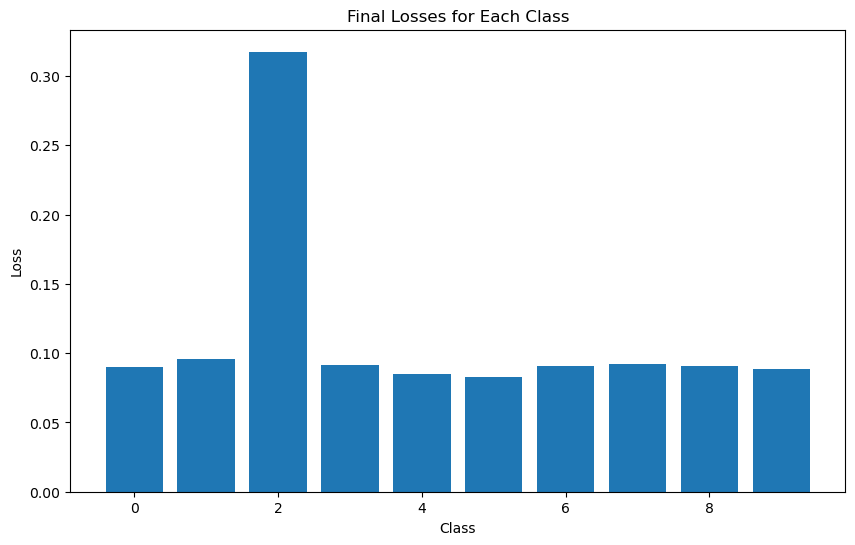

In [16]:
# Wyświetlanie strat dla każdej klasy po treningu
#plt.figure(figsize=(10, 6))
#for target_class, params in enumerate(params_list):
    # Obliczenie strat na zbiorze treningowym dla każdej klasy
    #losses = [cost(params, X_train, y_train, target_class) for epoch in range(num_epochs)]
    #plt.plot(losses, label=f'Class {target_class}')
#plt.title("Losses for Each Class During Training")
#plt.xlabel("Epochs")
#plt.ylabel("Loss")
#plt.legend()
#plt.show()
#szybsze wyświetlenie strat
plt.figure(figsize=(10, 6))
final_losses = [cost(params, X_train, y_train, target_class) for target_class, params in enumerate(params_list)]
plt.bar(range(num_classes), final_losses)
plt.title("Final Losses for Each Class")
plt.xlabel("Class")
plt.ylabel("Loss")
plt.show()

In [17]:
# Funkcja do predykcji
def predict(X):
    all_preds = np.array([[quantum_circuit(params, x) for params in params_list] for x in X])
    return np.argmax(all_preds, axis=1)

In [18]:
# Ewaluacja modelu z uwzględnieniem zero_division
y_pred = predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=1))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        43
           1       1.00      0.00      0.00        37
           2       1.00      0.00      0.00        38
           3       0.10      1.00      0.19        46
           4       1.00      0.00      0.00        55
           5       1.00      0.00      0.00        59
           6       1.00      0.00      0.00        45
           7       1.00      0.00      0.00        41
           8       1.00      0.00      0.00        38
           9       1.00      0.00      0.00        48

    accuracy                           0.10       450
   macro avg       0.91      0.10      0.02       450
weighted avg       0.91      0.10      0.02       450



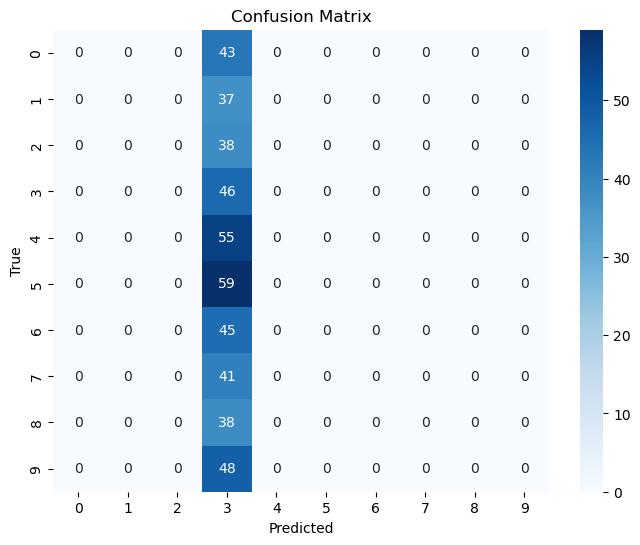

In [19]:
# Macierz konfuzji
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Obliczenie liczby poprawnych predykcji
correct_predictions = np.sum(y_pred == y_test)
total_predictions = len(y_test)

print(f"\nNumber of correct predictions: {correct_predictions} out of {total_predictions}")
print(f"Accuracy: {correct_predictions / total_predictions:.2%}")


Number of correct predictions: 46 out of 450
Accuracy: 10.22%
